# Face Generation with Gaussian Mixture Models
 
 This notebook is Part 2 of our face generation project, building on the dimensionality reduction achieved through PCA in Part 1. Here, we'll use Gaussian Mixture Models (GMM) to learn the distribution of faces in the reduced PCA space and generate new faces.

## Understanding Gaussian Mixture Models (GMM)

### Intuitive Explanation

 Imagine you're trying to describe the different types of faces you might see. You might say:
 - Some faces are round with large eyes
 - Others are more angular with defined cheekbones
 - Some have prominent noses and strong jaw lines
 - And so on...

 A Gaussian Mixture Model (GMM) works similarly. It says: "There are several different 'typical' face types, and each actual face is a variation of one of these types." More specifically:

 1. **Face Types** (Components):
    - Each "typical" face type is represented by a Gaussian distribution
    - A Gaussian distribution is like a bell curve in multiple dimensions
    - Each bell curve tells us how likely different variations of that face type are

 2. **Variations** (Covariance):
    - Some features might vary a lot within a face type
    - Other features might be more consistent
    - The model learns which variations are common for each face type

 3. **Frequency** (Weights):
    - Some face types might be more common than others
    - The model learns how frequently each face type occurs

 4. **Generation**:
    - To generate a new face:
      1. Pick a face type based on their frequencies
      2. Create a variation of that face type using its bell curve

### The Mathematics Behind GMM

#### Prerequisites from Probability Theory

 Before diving into GMM math, let's review some key concepts:

 1. **Probability Density Function (PDF)**:
    - A function that describes the relative likelihood of a random variable taking on a given value
    - The area under the curve equals 1
    - Higher values mean higher likelihood

 2. **Multivariate Gaussian Distribution**:
    - A bell-shaped probability distribution in multiple dimensions
    - Defined by:
      - μ (mu): The center (mean) vector
      - Σ (Sigma): The covariance matrix describing spread and correlation

 3. **Maximum Likelihood Estimation (MLE)**:
    - A method to find parameters that make the observed data most probable
    - "What model parameters would most likely generate our training data?"

#### The GMM Mathematical Framework

 A GMM is defined as a weighted sum of K Gaussian components:

 ```latex
 P(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)
 ```

 Where:
 - x: A data point (in our case, a face in PCA space)
 - K: Number of components (face types)
 - πk: Weight of component k (how common this face type is)
 - N(x | μk, Σk): Gaussian PDF for component k
 - μk: Mean vector for component k (the "typical" face of this type)
 - Σk: Covariance matrix for component k (how faces of this type vary)

 The Gaussian PDF is given by:

The Gaussian PDF is given by:

```latex
N(x | \mu, \Sigma) = (2\pi)^{-d/2} |\Sigma|^{-1/2} \exp\left(-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)\right)
```

 Where:
 - d: Dimension of x (120 in our case after PCA)
 - |Σ|: Determinant of Σ
 - Σ^(-1): Inverse of Σ

#### Training the Model: The EM Algorithm

 GMM parameters are learned using the Expectation-Maximization (EM) algorithm:

 1. **E-Step**: For each face, compute probability of belonging to each face type
    ```latex
    \gamma(z_{ik}) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_i | \mu_j, \Sigma_j)}
    ```
    where γ(z_ik) is the "responsibility" of component k for face i

 2. **M-Step**: Update parameters based on these probabilities
    ```latex
    \mu_k = \frac{\sum_{i=1}^N \gamma(z_{ik})x_i}{\sum_{i=1}^N \gamma(z_{ik})}
    ```
    ```latex
    \Sigma_k = \frac{\sum_{i=1}^N \gamma(z_{ik})(x_i-\mu_k)(x_i-\mu_k)^T}{\sum_{i=1}^N \gamma(z_{ik})}
    ```
    ```latex
    \pi_k = \frac{\sum_{i=1}^N \gamma(z_{ik})}{N}
    ```

 3. Repeat until convergence

#### Model Selection with AIC

 The Akaike Information Criterion helps us choose K:

 AIC = 2m - 2ln(L)

 Where:
 - m: Number of parameters (depends on K)
 - L: Maximum likelihood achieved
 - m = K(d + d(d+1)/2 + 1) - 1
   - K means, each d dimensions
   - K covariance matrices, each d×d
   - K weights (summing to 1)

## Import Libraries

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people

## Loading and Preparing Data

 We'll use the same preprocessing steps as in Part 1:
 1. Load the LFW dataset
 2. Apply PCA dimensionality reduction
 3. Work with the whitened PCA space

In [41]:
# Load faces with more samples for better modeling
faces = fetch_lfw_people(min_faces_per_person=50)
print(faces.target_names)
print(faces.images.shape)



['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']
(1560, 62, 47)


In [42]:
N = faces.images.shape[0]
M = faces.images.shape[1] * faces.images.shape[2]

print(f"Number of samples (N): {N}")
print(f"Number of features (M): {M}")

Number of samples (N): 1560
Number of features (M): 2914


In [43]:
# Apply PCA as before
pca = PCA(n_components=120, whiten=True)
data = pca.fit_transform(faces.images.reshape(N,-1))
print("PCA transformed shape:", data.shape)

PCA transformed shape: (1560, 120)


## Gaussian Mixture Model Optimization
  
 Now we need to determine the optimal number of Gaussian components to use in our mixture model. We'll use the Akaike Information Criterion (AIC) for model selection.

### Understanding AIC (Akaike Information Criterion)

 AIC is a mathematical method for model selection that helps us answer: "How many Gaussian components should we use in our mixture model?"
  
 The AIC score is calculated as:
 ```
 AIC = 2K - 2ln(L)
 ```
 Where:
 - K = number of parameters in the model (model complexity)
 - L = maximum likelihood of the model (how well it fits the data)

#### Why AIC Matters
  
 AIC helps us balance two competing goals:
 1. **Model Fit**: How well does the model describe our training data?
     - More components → Better fit
     - But too many components → Overfitting
 2. **Model Simplicity**: How simple/complex is our model?
     - More components → More complex model
     - More complexity → Higher risk of overfitting
  
#### In Face Generation Context
  
For our face generation task:
 - Too few components: Generated faces look too similar
 - Too many components: Model captures noise, not real patterns
 - Optimal components: Captures true variety in face features

In [44]:
# Fit GMM models with different numbers of components
n_components = np.arange(1, 200, 10)
gmm_models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]

### Model Selection Using AIC
  
For each number of components:
 1. Fit a GMM model
 2. Calculate AIC score
 3. Track the best model found

In [45]:
aic_values = []
lowest_aic = np.infty
best_gmm = None

for gmm in gmm_models:
    gmm.fit(data)
    aic = gmm.aic(data)
    aic_values.append(aic)
    if aic < lowest_aic:
        lowest_aic = aic
        best_gmm = gmm

print(f"Best number of components: {best_gmm.n_components}")

Best number of components: 31


### Analyzing Model Selection Results

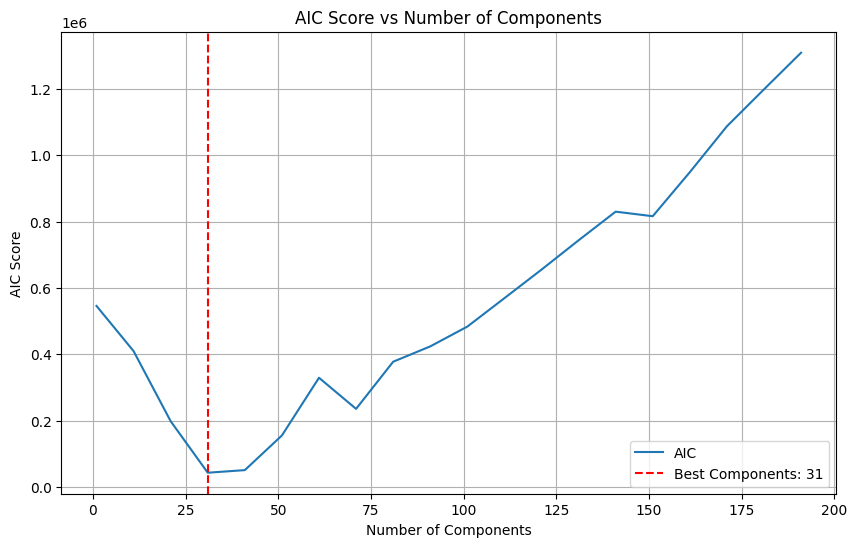

In [46]:
# Plot AIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('Number of Components')
plt.ylabel('AIC Score')
plt.title('AIC Score vs Number of Components')
plt.axvline(best_gmm.n_components, color='red', linestyle='--', 
            label=f'Best Components: {best_gmm.n_components}')
plt.legend()
plt.grid(True)
plt.show()


## Generating New Face Images
  
Now we can generate new faces through a three-step process:
 1. Sample points from our GMM in PCA space
 2. Transform these points back to image space using PCA inverse transform
 3. Reshape the data into face images

In [47]:
# Same function from PCA.ipynb
def plot_faces(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i], cmap='gray')

Generated samples shape: (1560, 120)
Reconstructed faces shape: (1560, 2914)


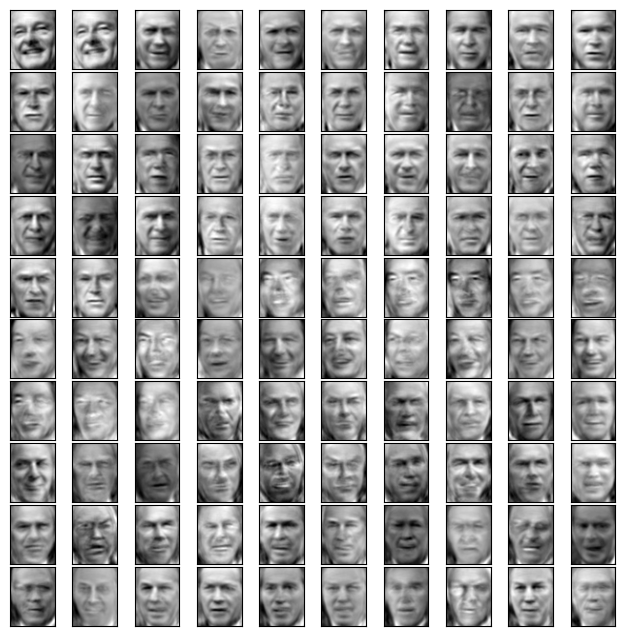

In [48]:
# Generate new samples using the GMM model
data_new = best_gmm.sample(N)
data_new = data_new[0]
print("Generated samples shape:", data_new.shape)

# Transform back to image space
faces_new = pca.inverse_transform(data_new)
print("Reconstructed faces shape:", faces_new.shape)

# Plot the generated faces
plot_faces(faces_new.reshape(-1, 62, 47))

## Results Analysis

### Quality of Generated Faces

 Our results demonstrate several key points:
 1. Generated faces maintain general facial structure
 2. Features (eyes, nose, mouth) are in correct positions
 3. Some blurriness due to dimensionality reduction
 4. Occasional artifacts in high-frequency details

### Understanding the Trade-offs

 Two critical choices affected our results:

 1. **Number of PCA Components (120)**
    - Controls the level of detail preserved
    - Balances reconstruction quality with model stability

 2. **Number of GMM Components ({best_gmm.n_components})**
    - Determined by AIC optimization
    - Balances variety of generated faces with model complexity

### Limitations and Considerations

 1. **Data Requirements**
    - Needs aligned faces
    - Consistent lighting helps
    - More data generally improves results

 2. **Computational Considerations**
    - PCA scales with data size
    - GMM fitting can be slow with many components
    - Memory usage increases with component count

 3. **Quality Trade-offs**
    - PCA loses high-frequency details
    - GMM assumes Gaussian distributions
    - Limited ability to capture fine details


## Practical Applications

 This technique has several practical applications:

 1. **Face Recognition**
    - Efficient face encoding
    - Feature extraction
    - Similarity measurement

 2. **Data Augmentation**
    - Generate training data
    - Create variations of faces
    - Test face recognition systems

 3. **Computer Graphics**
    - Avatar generation
    - Face editing
    - Animation bases

## Conclusion

 The combination of PCA and GMM provides an elegant framework for understanding and generating facial images. While modern deep learning approaches may offer better quality, this lassical approach provides valuable insights into:

 1. The structure of face data
 2. The principles of generative modeling
 3. The importance of dimensionality reduction
 4. The balance between model complexity and performance

 The interpretability of eigenfaces and the probabilistic nature of GMM make this approach particularly valuable for educational purposes and for understanding the fundamental hallenges in face generation and recognition tasks.